<a href="https://colab.research.google.com/github/A-Bane/RL/blob/main/Policy_Iteration_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Policy evaluation
- Evaluates a given policy
- Evaluates how? By the value of each state
- What does the value function tell us about the policy?


In [ ]:
 !pip3 install gym --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 14.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827626 sha256=5aadd16c1eb676c2a1bc149632fbc1a62cf6162c7341600a3014743a3bfccd47
  Stored in directory: /root/.cache/pip/wheels/b9/22/6d/3e7b32d98451b4cd9d12417052affbeeeea012955d437da1da
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.0.9 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.


In [ ]:
import torch
import gym
env = gym.make('FrozenLake-v1', render_mode = "rgb_array")

In [ ]:
gamma = 0.99 # Note 0.99 discount factor makes long-term values more priority than immediate rewards
threshold = 0.0001

Recall the following:

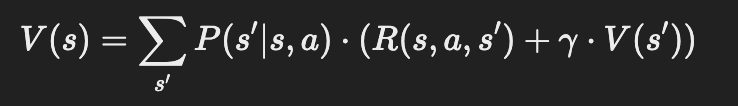

In [25]:
def policy_evaluation(env, policy, gamma, threshold):
  """
   Perform policy evaluation
   Ouputs the value of each state for the given policy
   @param env: OpenAI Gym environment
   @param policy: policy matrix containing actions and their probability in each state > for eg. s1->[a1,a2,a3], s2->[a1,a2,a3] etc
   @param gamma: discount factor
   @param threshold: the evaluation will stop once values for all states are less than the threshold
   @return: values of the given policy
  """
  n_states = env.observation_space.n
  n_actions = env.action_space.n
  V_temp = torch.zeros(n_states)

  while True:
    V = V_temp.clone()
    V_temp = torch.zeros(n_states)
    for state_id in range(n_states):
      # Here are they taking a sum over the action space or are they taking the value of the state for the action for which the value is maximum?
      # Here the action is already given by the policy
      action = int(policy[state_id].item())

      """Why we do this and not env.step(action)?
      new_state, reward, is_done, truncated, info <-- env.step(action)  # trans_prob is inside <info> as a dictionary
      For eg. (0, 0.0, False, False, {'prob': 0.3333333333333333})

      trans_prob, new_state, reward, _ <-- env.env.P[state_id][action]  # Note that this new state is not all the states possible
      For eg. [(0.3333333333333333, 1, 0.0, False), (0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 0, 0.0, False)]

      Therefore env.env.P[state_id][action] gives the set of all possible new states on taking action a.
      env.step(action) chooses a new state given the probabilities and action a
      """

      for trans_prob, new_state, reward, _ in env.env.P[state_id][action]:
        V_temp[state_id] += trans_prob * (reward + gamma * V[int(new_state)])  # In VI, here the values are directly computed for the action that produces maximum value only and not the summation

    max_delta = torch.max(torch.abs(V-V_temp))
    if max_delta<=threshold:
      break

  return V_temp


Policy Improvement:
- Here the values are already provided
- What does the value of each state look like? V = [0.1, 1, 2, ...]
- Value of each each is not provided only state values are provided
- Based on the values of the states, choose an appropriate action
- How can we select an action based on the state values?
- We need to calculate the action values for each state (this is not available in the state values)
- Choose the action for which the state value is max


In [48]:
def policy_improvement(env, V, gamma):
  """
  Obtain an improved policy based on the values
  @param env: OpenAI Gym environment
  @param V: policy values
  @param gamma: discount factor
  @return: the policy
  """
  n_states = len(V)
  n_actions = env.action_space.n
  Q = torch.zeros((n_states, n_actions))
  policy = torch.zeros(n_states)
  for state_id in range(n_states):
    Q[state_id] = torch.zeros(n_actions)  # Q[s,a] is the value of action a at state s
    for action_id in range(len(Q[state_id])):
      for trans_prob, new_state, reward, _ in env.env.P[state_id][action_id]:
        Q[state_id][action_id] += trans_prob * (reward + gamma * V[int(new_state)])  # the value of each action is based on the values of the states it reaches and the reward it gets
    policy[state_id] = torch.argmax(Q[state_id])  # argmax gives the action_id of the one with maximum value

  return policy


Now that we have the policy evaluation step (to find the values of each state) and the policy improvement step (to choose the actions that maximize the values of each state), we can put these two steps into a loop called the policy iteration function.

In [44]:
def policy_iteration(env, gamma, threshold):
  """
  Solve a given environment with policy iteration algorithm
  @param env: OpenAI Gym environment
  @param gamma: discount factor
  @param threshold: the evaluation will stop once values
                        for all states are less than the threshold
  @return: optimal values and the optimal policy for the given
                  environment
  """
  # 1. Initialize a random policy
  # 2. Compute how good the policy is - by the values of each states
  # 3. Improve the policy - based on the values, choose the actions that has the max state value

  # How long do you run the policy iterations?
  # Till the policy converge

  n_states = env.observation_space.n
  n_actions = env.action_space.n
  policy = torch.randint(high=n_actions, size=(n_states,)).float()

  while True:
    policy_before = policy.clone()
    V = policy_evaluation(env, policy, gamma, threshold)
    policy = policy_improvement(env, V, gamma)

    if torch.equal(policy_before, policy):
      return V, policy
      break

In [51]:
V_optimal, optimal_policy = policy_iteration(env, gamma, threshold)
optimal_policy

tensor([0., 3., 3., 3., 0., 0., 0., 0., 3., 1., 0., 0., 0., 2., 1., 0.])

What is the difference between VI and PI?
- VI extracts values of a state. These values are optimal, and then extracts the optimal policy out of the values.
- PI extracts values of a state (optimal), creates a policy, then again creates value based on the policy.
- VI therefore does not depend on a policy. It loops through all possible actions.
- PI's value function depends on the action given by the policy.

Which one to use VI or PI?
- VI does not iteratively alternate between policy evaluation and improvement.
- However, VI is slower than PI.
- Why?
- Because as VI has no access to policy, the value function extraction step longer to converge, as it has to go through each action individually.
- So if the number of actions is large, use PI over VI.
- VI is memory efficient